# Revision

Reviewers commented that the selection of cutoffs could be improved by providing users with more information. So we opted to improve our clairty in this section.

The goal is to now create the predictions for uniref375 dataset with the variance and the mean prediction values. These will then be used as the cutoffs for the other downstream models - we can see better then whether it generalizes.




In [1]:
import pandas as pd

from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt

def compute_uncertainties(df, prob_columns, mean_prob=0.5):
    means, aleatorics, epistemics, residues, variance, entropy_values  = [], [], [], [], [], []
    for p1, p2, p3, p4, p5 in tqdm(df[prob_columns].values):
        mean_values = []
        aleatoric_values = []
        epistemic_values = []
        variance_values = []
        entropys = []
        indicies = []
        for j in range(0, len(p1)):
            eps = 1e-8 # For non-zeros
            all_probs = [p1[j] + eps, p2[j] + eps, p3[j] + eps, p4[j] + eps, p5[j] + eps]
            mean_probs = np.mean(all_probs)
            entropy = -((mean_probs * np.log2(mean_probs)) + ((1 - mean_probs) * np.log2(1 - mean_probs)))
            epistemic = np.var(all_probs) # use variance as a proxy
            indicies.append(j)
            mean_values.append(mean_probs)
            epistemic_values.append(epistemic)
            entropys.append(entropy)
        means.append(mean_values)
        epistemics.append(epistemic_values)
        entropy_values.append(entropys)
        
        residues.append('|'.join([str(s) for s in indicies]))
    return means, entropy_values, epistemics, residues
    
def calculate_stats_uncertainty(df, id_col, true_col, pred_col, seq_col):   
    # Check the agreement:
    rows = []
    for seq_label, res_sq, res_pred, seq, mean_prob, alea, var in df[[id_col, true_col, pred_col, seq_col, 'mean_prob', 'entropy', 'variance']].values:
        if not res_sq:
            missing += 1
        else:
            res_sq = res_sq.split('|')
            res_sq = [int(i) for i in res_sq]
            for pos in range(0, len(seq)):
                if pos in res_sq:
                    rows.append([seq_label, pos, seq[pos], 1, mean_prob[pos], alea[pos], var[pos]])
                else:
                    rows.append([seq_label, pos, seq[pos], 0, mean_prob[pos], alea[pos], var[pos]])

    return pd.DataFrame(rows, columns=['Entry', 'Position', 'Residue', 'Catalytic Pred', 'Mean Prob', 'Entropy', 'Variance'])


# Run each model separately so that we can test different strategies for ensembling

Ran the following on each of the first five AEGAN models:

```
 squidly run /disk1/ariane/vscode/squidly/revision/data/uni3175/uni3175_unduplicated.fasta esm2_t36_3B_UR50D output/uni3175_aegan/model1/ cataloDB_3B --as-threshold 0.5 --lstm-model-as ../models/FinalModels/CLEANED_reproducing_AEGAN_benchmark_squidly_scheme_3_esm2_t36_3B_UR50D_2025-03-04/Scheme3_16000_1/3B/LSTM_3B.pth --cr-model-as ../models/FinalModels/CLEANED_reproducing_AEGAN_benchmark_squidly_scheme_3_esm2_t36_3B_UR50D_2025-03-04/Scheme3_16000_1/3B/CL_3B.pt --no-ensemble

squidly run /disk1/ariane/vscode/squidly/revision/data/uni3175/uni3175_unduplicated.fasta esm2_t36_3B_UR50D output/uni3175_aegan/model2/ cataloDB_3B --as-threshold 0.5 --lstm-model-as ../models/FinalModels/CLEANED_reproducing_AEGAN_benchmark_squidly_scheme_3_esm2_t36_3B_UR50D_2025-03-04/Scheme3_16000_2/3B/LSTM_3B.pth --cr-model-as ../models/FinalModels/CLEANED_reproducing_AEGAN_benchmark_squidly_scheme_3_esm2_t36_3B_UR50D_2025-03-04/Scheme3_16000_2/3B/CL_3B.pt --no-ensemble

squidly run /disk1/ariane/vscode/squidly/revision/data/uni3175/uni3175_unduplicated.fasta esm2_t36_3B_UR50D output/uni3175_aegan/model3/ cataloDB_3B --as-threshold 0.5 --lstm-model-as ../models/FinalModels/CLEANED_reproducing_AEGAN_benchmark_squidly_scheme_3_esm2_t36_3B_UR50D_2025-03-04/Scheme3_16000_3/3B/LSTM_3B.pth --cr-model-as ../models/FinalModels/CLEANED_reproducing_AEGAN_benchmark_squidly_scheme_3_esm2_t36_3B_UR50D_2025-03-04/Scheme3_16000_3/3B/CL_3B.pt --no-ensemble

squidly run /disk1/ariane/vscode/squidly/revision/data/uni3175/uni3175_unduplicated.fasta esm2_t36_3B_UR50D output/uni3175_aegan/model4/ cataloDB_3B --as-threshold 0.5 --lstm-model-as ../models/FinalModels/CLEANED_reproducing_AEGAN_benchmark_squidly_scheme_3_esm2_t36_3B_UR50D_2025-03-04/Scheme3_16000_4/3B/LSTM_3B.pth --cr-model-as ../models/FinalModels/CLEANED_reproducing_AEGAN_benchmark_squidly_scheme_3_esm2_t36_3B_UR50D_2025-03-04/Scheme3_16000_4/3B/CL_3B.pt --no-ensemble

squidly run /disk1/ariane/vscode/squidly/revision/data/uni3175/uni3175_unduplicated.fasta esm2_t36_3B_UR50D output/uni3175_aegan/model5/ cataloDB_3B --as-threshold 0.5 --lstm-model-as ../models/FinalModels/CLEANED_reproducing_AEGAN_benchmark_squidly_scheme_3_esm2_t36_3B_UR50D_2025-03-04/Scheme3_16000_5/3B/LSTM_3B.pth --cr-model-as ../models/FinalModels/CLEANED_reproducing_AEGAN_benchmark_squidly_scheme_3_esm2_t36_3B_UR50D_2025-03-04/Scheme3_16000_5/3B/CL_3B.pt --no-ensemble


```

In [33]:
import os 
# 15B model
for i in range(1, 6):
    # Get the model 
    cr_model = f'../models/FinalModels/CLEANED_reproducing_AEGAN_benchmark_squidly_scheme_3_esm2_t48_15B_UR50D_2025-03-03/Scheme3_16000_{i}/models/temp_best_model.pt'
    lstm_model_name = os.listdir(f'../models/FinalModels/CLEANED_reproducing_AEGAN_benchmark_squidly_scheme_3_esm2_t48_15B_UR50D_2025-03-03/Scheme3_16000_{i}/LSTM/models/')[0]
    lstm_model = f'../models/FinalModels/CLEANED_reproducing_AEGAN_benchmark_squidly_scheme_3_esm2_t48_15B_UR50D_2025-03-03/Scheme3_16000_{i}/LSTM/models/{lstm_model_name}'
    print(f'squidly run data/uni3175/uni3175_unduplicated.fasta esm2_t48_15B_UR50D output/uni3175_aegan/15B/model{i}/ cataloDB_15B --as-threshold 0.5 --lstm-model-as {lstm_model} --cr-model-as {cr_model} --no-ensemble')

squidly run data/uni3175/uni3175_unduplicated.fasta esm2_t48_15B_UR50D output/uni3175_aegan/15B/model1/ cataloDB_15B --as-threshold 0.5 --lstm-model-as ../models/FinalModels/CLEANED_reproducing_AEGAN_benchmark_squidly_scheme_3_esm2_t48_15B_UR50D_2025-03-03/Scheme3_16000_1/LSTM/models/03-03-25_13-38_128_2_0.2_400_best_model.pth --cr-model-as ../models/FinalModels/CLEANED_reproducing_AEGAN_benchmark_squidly_scheme_3_esm2_t48_15B_UR50D_2025-03-03/Scheme3_16000_1/models/temp_best_model.pt --no-ensemble
squidly run data/uni3175/uni3175_unduplicated.fasta esm2_t48_15B_UR50D output/uni3175_aegan/15B/model2/ cataloDB_15B --as-threshold 0.5 --lstm-model-as ../models/FinalModels/CLEANED_reproducing_AEGAN_benchmark_squidly_scheme_3_esm2_t48_15B_UR50D_2025-03-03/Scheme3_16000_2/LSTM/models/03-03-25_15-07_128_2_0.2_400_best_model.pth --cr-model-as ../models/FinalModels/CLEANED_reproducing_AEGAN_benchmark_squidly_scheme_3_esm2_t48_15B_UR50D_2025-03-03/Scheme3_16000_2/models/temp_best_model.pt --no-e

In [ ]:
import os 

for i in range(1, 6):
    # Get the model 
    cr_model = f'../models/FinalModels/CLEANED_reproducing_AEGAN_benchmark_squidly_scheme_3_esm2_t36_3B_UR50D_2025-03-04/Scheme3_16000_{i}/models/temp_best_model.pt'
    lstm_model_name = os.listdir(f'../models/FinalModels/CLEANED_reproducing_AEGAN_benchmark_squidly_scheme_3_esm2_t36_3B_UR50D_2025-03-04/Scheme3_16000_{i}/LSTM/models/')[0]
    lstm_model = f'../models/FinalModels/CLEANED_reproducing_AEGAN_benchmark_squidly_scheme_3_esm2_t36_3B_UR50D_2025-03-04/Scheme3_16000_{i}/LSTM/models/{lstm_model_name}'
    print(f'squidly run data/uni3175/uni3175_unduplicated.fasta esm2_t36_3B_UR50D output/uni3175_aegan/model{i}/ cataloDB_3B --as-threshold 0.5 --lstm-model-as {lstm_model} --cr-model-as {cr_model} --no-ensemble')

# See what the F1, precision and recall are for different cutoff values

In [21]:
from tqdm import tqdm 

# First join each of the data frames from the individual runs then compute the uncertainties 
squidly_ensemble = pd.read_pickle('output/uni3175_aegan/model5//cataloDB_3B_squidly.pkl')
for model_i in range(2, 6):
    squidly_df = pd.read_pickle(f'output/uni3175_aegan/model{model_i}/cataloDB_3B_squidly.pkl')
    squidly_ensemble = squidly_ensemble.join(squidly_df, how='outer', rsuffix=f'_{model_i - 1}')

means, entropy_values, epistemics, residues = compute_uncertainties(squidly_ensemble, ['all_AS_probs', 'all_AS_probs_1', 'all_AS_probs_2', 'all_AS_probs_3', 'all_AS_probs_4'], 0.5)
squidly_ensemble['mean_prob'] = means
squidly_ensemble['entropy'] = entropy_values
squidly_ensemble['variance'] = epistemics
squidly_ensemble['residues'] = residues
squidly_ensemble.set_index('label', inplace=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1954/1954 [00:29<00:00, 65.49it/s]


In [22]:
# Read in the "true" residues and then we can check the acc
true_df = pd.read_csv('data/uni3175/uni3175_unduplicated.tsv', sep='\t')
def annotate_residue_from_uniprot(df):
    # Organise the active sites of these guys to be better
    active_sites = []
    active_site_residue_counts = []
    x = 0
    for act_site in df['Active site'].values:
        sites = []
        if isinstance(act_site, str):
            act_site = act_site.replace(" ", '')
            for act in act_site.split('ACT_SITE'):
                try:
                    sites.append(int(act.split(';')[0].replace(" ", '')) - 1) # Need to subtract 1 to make it fit with the fact that python is 0 encoded lol
                except:
                    x = 1
        if len(sites) != 0:
            active_sites.append('|'.join([str(s) for s in sites]))
            active_site_residue_counts.append(len(sites))
        else:
            active_sites.append('None')
            active_site_residue_counts.append(0)
    df['Residue'] = active_sites
    df['active_site_residue_counts'] = active_site_residue_counts
    return df
    
true_df = annotate_residue_from_uniprot(true_df)
true_df.set_index('From', inplace=True)
true_df = true_df.join(squidly_ensemble, how='left')


# Calculate variance and mean values across the predictions

In [23]:
unc_df = calculate_stats_uncertainty(true_df, 'Entry', 'Residue', 'residues', 'Sequence')
unc_df

,Entry,Position,Residue,Catalytic Pred,Mean Prob,Entropy,Variance
0,A0A084JZA8,0,M,0,0.00158,0.016981,6.696000e-07
1,A0A084JZA8,1,I,0,0.00128,0.014146,2.296000e-07
2,A0A084JZA8,2,I,0,0.00112,0.012594,1.296000e-07
3,A0A084JZA8,3,K,0,0.00102,0.011607,1.336000e-07
4,A0A084JZA8,4,Q,0,0.00100,0.011408,1.440000e-07
...,...,...,...,...,...,...,...
748003,W7N293,458,Q,0,0.00108,0.012201,6.960000e-08
748004,W7N293,459,R,0,0.00106,0.012003,7.840000e-08
748005,W7N293,460,A,0,0.00104,0.011805,5.840000e-08
748006,W7N293,461,A,0,0.00104,0.011805,6.400000e-09


Text(0.5, 1.0, '15B Mean vs Variance')

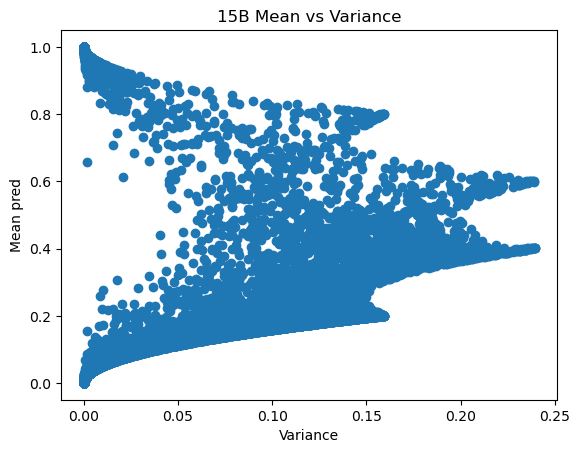

In [25]:
plt.scatter(unc_df['Variance'].values, unc_df['Mean Prob'].values)
plt.xlabel('Variance')
plt.ylabel('Mean pred')
plt.title('15B Mean vs Variance')

In [27]:
from collections import defaultdict
cols = defaultdict(list)
for mean_prob in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
    for vari in [0.05, 0.0725, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25]:
        # Make a pred
        preds_prob = 1.0 * unc_df['Mean Prob'].values > mean_prob
        preds_var = 1.0 * unc_df['Variance'].values < vari
        cols[f'm{mean_prob}_v{vari}'] = 1.0*preds_prob*preds_var

In [28]:
for c in cols:
    unc_df[c] = cols[c]
# Now calculate the different predictions for each of them
rows = []
for c in cols:
    precision, recall, f1, support = precision_recall_fscore_support(list(unc_df['Catalytic Pred'].values), list(unc_df[c].values))
    # Maybe save the 0's too but for now look only at precision and recall of getting one correct
    rows.append([c, c.split('_')[0][1:], c.split('_')[1][1:], precision[1], recall[1], f1[1], support[1]])
    

/tmp/ipykernel_1598745/930700681.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  unc_df[c] = cols[c]
/tmp/ipykernel_1598745/930700681.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  unc_df[c] = cols[c]
/tmp/ipykernel_1598745/930700681.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  unc_df

In [29]:
pred_df = pd.DataFrame(rows, columns=['label', 'mean_pred', 'variance', 'precision', 'recall', 'f1', 'support'])

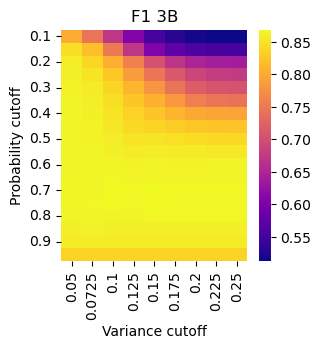

In [37]:
import seaborn as sns
model = '3B' 
plt.rcParams['figure.figsize'] = (3,3)

df_plot = pd.DataFrame(pred_df, columns=["mean_pred", "variance", "f1"])
pivot = df_plot.pivot("mean_pred", "variance", "f1")
sns.heatmap(pivot, annot=False, cmap="plasma")
plt.yticks(rotation=0) 
plt.ylabel("Prediction cutoff")
plt.xlabel("Variance cutoff")
plt.title(f'F1 {model}')
plt.savefig(f'figs/{model}_F1_no_annot_uni3175.svg', bbox_inches='tight')

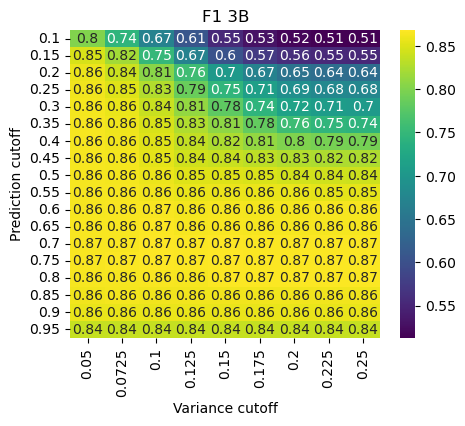

In [43]:
plt.rcParams['figure.figsize'] = (5,4)

df_plot = pd.DataFrame(pred_df, columns=["mean_pred", "variance", "f1"])
pivot = df_plot.pivot("mean_pred", "variance", "f1")
sns.heatmap(pivot, annot=True, cmap="viridis")
plt.ylabel("Prediction cutoff")
plt.xlabel("Variance cutoff")
plt.title(f'F1 {model}')
plt.savefig(f'figs/{model}_F1_uni3175.svg', bbox_inches='tight')

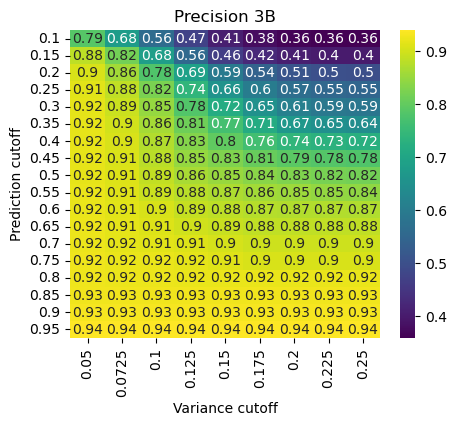

In [40]:
import seaborn as sns

plt.rcParams['figure.figsize'] = (5,4)

df_plot = pd.DataFrame(pred_df, columns=["mean_pred", "variance", "precision"])
pivot = df_plot.pivot("mean_pred", "variance", "precision")
sns.heatmap(pivot, annot=True, cmap="viridis")
plt.ylabel("Prediction cutoff")
plt.xlabel("Variance cutoff")
plt.title(f'Precision {model}')
plt.savefig(f'figs/{model}_precision_uni3175.svg', bbox_inches='tight')

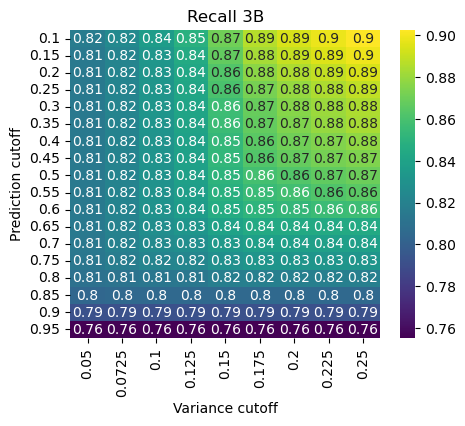

In [41]:
import seaborn as sns

plt.rcParams['figure.figsize'] = (5,4)

df_plot = pd.DataFrame(pred_df, columns=["mean_pred", "variance", "recall"])
pivot = df_plot.pivot("mean_pred", "variance", "recall")
sns.heatmap(pivot, annot=True, cmap="viridis")
plt.ylabel("Prediction cutoff")
plt.xlabel("Variance cutoff")
plt.title(f'Recall {model}')
plt.savefig(f'figs/{model}_recall_uni3175.svg', bbox_inches='tight')

# Results summary

What we can see is that there is a tradeoff (expected) between precision and recall. 

Using a cutoff of 0.6 and 0.15 gives a good precision (0.88 and recall 0.85) if we move in either direction we get a lower recall - even though we can get a "higher" F1 overall.